In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import zscore

#데이터 전처리

#데이터 보기

In [ ]:
#이부분은 각자 저장 위치 수정해서 런타임 실행
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
#df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

##피쳐 엔지니어링

###중개사무소를 중개사무소별 허위매물 비율로 대체

In [ ]:
total_counts = df['중개사무소'].value_counts()

# 2. 허위매물 수 집계
false_counts = df[df['허위매물여부'] == 1]['중개사무소'].value_counts()

# 3. 비율 계산
false_ratio = (false_counts / total_counts * 100).fillna(0).round(2)

# 4. 정리된 결과
result = pd.DataFrame({
    '전체매물수': total_counts,
    '허위매물수': false_counts,
    '허위매물비율(%)': false_ratio
}).fillna(0).astype({'허위매물수': int})

# 비율 기준 정렬 (선택)
result = result.sort_values('허위매물비율(%)', ascending=False)

df['허위매물비율'] = df['중개사무소'].map(result['허위매물비율(%)'])

NameError: name 'df' is not defined

In [ ]:
# 1. 공통 중개사무소(agency) 찾기
common_agencies = set(df['중개사무소']) & set(df_test['중개사무소'])

# 2. df에서 agency별 허위매물비율 계산
#    (허위매물여부 컬럼은 1이 허위매물이라 가정)
agency_false_ratio = (
    df.groupby('중개사무소')['허위매물여부']
    .mean()  # 허위매물 비율
)

# 3. 중앙값 계산 (df 전체 agency의 허위매물비율 기준)
default_ratio = agency_false_ratio.median()

# 4. df_test에 허위매물비율 컬럼 생성
def get_false_ratio(agency):
    if agency in agency_false_ratio:
        return agency_false_ratio[agency]
    else:
        return default_ratio

df_test['허위매물비율'] = df_test['중개사무소'].apply(get_false_ratio)

In [ ]:
df_test.to_csv("df_test")

###독립변수와 종속변수 분리

In [ ]:
#독립변수와 종속변수 분리, ID컬럼 드랍
df_x = df[['매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
           '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물비율']]
df_y = df[["허위매물여부"]]

In [ ]:
df_x

In [ ]:
df_y.head()

#결측치 처리

##변수 간 상관관계 검정

In [ ]:
#귀무가설 : target_columns과 reference_columns는 상관관계가 없을 것이다.
#대립가설 : target_columns과 reference_columns는 상관관계가 있을 것이다.
#P-value : 귀무가설이 참일 확률

#결측치 처리를 위한 상관관계 검정
from scipy.stats import pearsonr

# 상관관계 검정을 위한 대상 컬럼
target_columns = ["전용면적", "해당층", "총층", "방수", "욕실수", "총주차대수"]
reference_columns = ["보증금", "월세"]

# 유의수준 설정 (일반적으로 0.05 사용)
alpha = 0.05

# 결과 저장 리스트
correlation_results = []

# 각 대상 컬럼과 보증금, 월세 간의 피어슨 상관계수 및 p-value 계산
for target in target_columns:
    for ref in reference_columns:
        # 결측치를 제외하고 피어슨 상관계수 검정 수행
        non_null_data = df[[target, ref]].dropna()
        if len(non_null_data) > 2:  # 최소한의 샘플 수 확인
            corr_coef, p_value = pearsonr(non_null_data[target], non_null_data[ref])
            correlation_results.append([target, ref, corr_coef, p_value, p_value < alpha])

# 결과를 데이터프레임으로 정리
correlation_df = pd.DataFrame(
    correlation_results,
    columns=["변수", "참조 변수", "상관계수", "p-value", "유의한 관계 여부 (p < 0.05)"]
)

# 결과 표시
correlation_df[correlation_df["유의한 관계 여부 (p < 0.05)"] == True]

,변수,참조 변수,상관계수,p-value,유의한 관계 여부 (p < 0.05)
3,해당층,월세,-0.046866,0.027129,True
7,방수,월세,-0.041248,0.041786,True


##결측치 처리 실행

In [ ]:

#총주차대수, 욕실수 결측치 처리
#df_x['총층'].fillna(df_x['총층'].mean(), inplace=True)
df_x['총주차대수'].fillna(df_x['총주차대수'].mean(), inplace=True)
df_x['욕실수'].fillna(1, inplace=True)


<ipython-input-48-a6058bf5ef9d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_x['총주차대수'].fillna(df_x['총주차대수'].mean(), inplace=True)
<ipython-input-48-a6058bf5ef9d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [ ]:

# 방수와 월세를 본 다음 1 또는 2로 설정
# 랜덤포레스트를 활용
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_non_null = df_x[df_x['방수'].notnull()]
X = df_non_null[['월세']]
y = df_non_null['방수']

# 모델 학습
model = RandomForestClassifier()
model.fit(X, y)

# 방수 결측치 예측
df_null = df_x[df_x['방수'].isnull()]
df_x.loc[df_x['방수'].isnull(), '방수'] = model.predict(df_null[['월세']])
#이 오류는 무시해도 됨

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 해당층이 있는 데이터만 활용하여 학습 데이터 생성
df_non_null = df_x[df_x['해당층'].notnull()]
X = df_non_null[['월세']]
y = df_non_null['해당층']

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 해당층 결측치 예측
df_null = df_x[df_x['해당층'].isnull()]
df_x.loc[df_x['해당층'].isnull(), '해당층'] = model.predict(df_null[['월세']])

# 1층 미만, 총층 초과 방지
df_x['해당층'] = df_x['해당층'].round().clip(1, df_x['총층'])

In [ ]:

from sklearn.ensemble import RandomForestRegressor

# 해당층이 있는 데이터만 활용하여 학습 데이터 생성
df_non_null = df_x[df_x['총층'].notnull()]
X = df_non_null[['해당층']]
y = df_non_null['총층']

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 해당층 결측치 예측
df_null = df_x[df_x['총층'].isnull()]
df_x.loc[df_x['총층'].isnull(), '총층'] = model.predict(df_null[['해당층']])

# 1층 미만, 총층 초과 방지
df_x['해당층'] = df_x['해당층'].round().clip(1, df_x['총층'])


In [ ]:
#전용면적은 방수별 평균으로 대체
df_x.pivot_table(index='방수', values='전용면적', aggfunc='mean')

,전용면적
방수,
1.0,25.078175
2.0,31.203638


In [ ]:

# 방수별 전용면적 평균을 활용하여 결측치 대체
area_mapping = {1.0: 25.08, 2.0: 31.2}

# 전용면적이 결측치인 경우, 방수 값에 따라 대체
df_x.loc[df_x['전용면적'].isnull(), '전용면적'] = df_x['방수'].map(area_mapping)


In [ ]:
df_x.isnull().sum()

,0
ID,0
보증금,0
월세,0
전용면적,0
해당층,0
총층,0
방수,0
욕실수,0
총주차대수,0
관리비,0


#데이터 형태 변환

In [ ]:
# 중개사무소 컬럼 삭제
df = df.drop(columns=['중개사무소'])
df_test = df_test.drop(columns=['중개사무소'])

KeyError: "['중개사무소'] not found in axis"

In [ ]:
df_x

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물비율
0,현장확인,402500000.0,470000,25.08,5.0,15.0,서향,1.0,1.0,가능,40.000000,96,t93Nt6I2I0,B플랫폼,2024-10-09,33.33
1,현장확인,170500000.0,200000,31.20,3.0,4.0,남동향,2.0,1.0,불가능,20.332574,0,q39iV5J4E6,D플랫폼,2024-12-26,0.00
2,전화확인,114000000.0,380000,25.08,2.0,3.0,동향,1.0,1.0,불가능,20.332574,0,b03oE4G3F6,A플랫폼,2024-11-28,5.26
3,현장확인,163500000.0,30000,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.000000,10,G52Iz8V2B9,A플랫폼,2024-11-26,0.00
4,현장확인,346000000.0,530000,31.20,3.0,3.0,동향,2.0,1.0,불가능,20.332574,0,N45gM0M7R0,B플랫폼,2024-06-25,5.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,서류확인,159000000.0,550000,48.95,3.0,3.0,남향,2.0,1.0,불가능,20.332574,0,d22DX4Y4P8,B플랫폼,2024-11-16,6.25
2448,서류확인,158500000.0,750000,25.08,2.0,4.0,남향,1.0,1.0,불가능,20.332574,2,g99sy3I3R8,A플랫폼,2024-10-06,0.00
2449,전화확인,329000000.0,610000,17.50,8.0,20.0,남서향,1.0,1.0,가능,29.000000,10,G52Iz8V2B9,B플랫폼,2024-05-15,0.00
2450,현장확인,31000000.0,400000,22.87,8.0,9.0,남동향,2.0,1.0,가능,20.332574,8,m69GM9O9B3,B플랫폼,2024-08-06,26.32


In [ ]:
# 날짜 컬럼이 '게재일'이라고 가정
df_x['게재일'] = pd.to_datetime(df_x['게재일'])  # 날짜 형식 변환

# 연도, 월, 일, 요일 등의 숫자로 변환
df_x['게재_연도'] = df_x['게재일'].dt.year
df_x['게재_월'] = df_x['게재일'].dt.month
df_x['게재_일'] = df_x['게재일'].dt.day


# 원본 날짜 컬럼 제거 (트리 모델에서는 필요 없음)
df_x.drop(columns=['게재일'], inplace=True)

# 변환된 데이터 확인
print(df_x[['게재_연도', '게재_월', '게재_일']].head())

   게재_연도  게재_월  게재_일
0   2024    10     9
1   2024    12    26
2   2024    11    28
3   2024    11    26
4   2024     6    25


In [ ]:
df_test['게재일'] = pd.to_datetime(df_test['게재일'])  # 날짜 형식 변환
# 연도, 월, 일, 요일 등의 숫자로 변환
df_test['게재_연도'] = df_test['게재일'].dt.year
df_test['게재_월'] = df_test['게재일'].dt.month
df_test['게재_일'] = df_test['게재일'].dt.day


# 원본 날짜 컬럼 제거 (트리 모델에서는 필요 없음)
df_test.drop(columns=['게재일'], inplace=True)

# 변환된 데이터 확인
print(df_test[['게재_연도', '게재_월', '게재_일']].head())

   게재_연도  게재_월  게재_일
0   2024    10    21
1   2023     9     2
2   2024     4     3
3   2024     9    19
4   2024    11    10


In [ ]:
#df_x["방향"].unique() #['서향', '남동향', '동향', '남향', '북동향', '북향', '남서향', '북서향']
df_x["매물확인방식"].unique() #['현장확인', '전화확인', '서류확인']
#df_x["중개사무소"].unique() #난수
#df_x["제공플랫폼"].unique() #'B플랫폼', 'D플랫폼', 'A플랫폼', 'C플랫폼', 'F플랫폼', 'G플랫폼', 'E플랫폼', 'J플랫폼','H플랫폼', 'I플랫폼', 'L플랫폼', 'K플랫폼', 'M플랫폼'
#df_x["주차가능여부"].unique() #['가능', '불가능']

array(['현장확인', '전화확인', '서류확인'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd

# 타깃 인코딩할 컬럼 리스트
encode_cols = ['매물확인방식', '방향', '주차가능여부', '제공플랫폼']

# 타깃 컬럼 (예: '허위매물여부')
target_col = '허위매물여부'

# 전체 타깃 평균 (학습 데이터 기준)
global_mean = df[target_col].mean()

# 타깃 인코딩을 위한 함수 (스무딩 적용)
def target_encode(train_series, target, min_samples_leaf=1, smoothing=10):
    """
    각 범주별 target의 평균값에 스무딩을 적용한 타깃 인코딩 값을 반환합니다.

    smoothing: 카테고리별 샘플 수가 적은 경우 global mean에 가까워지도록 함.
    """
    # 각 범주의 평균과 count 계산
    agg = train_series.to_frame().join(target).groupby(train_series.name)[target.name].agg(['mean', 'count'])
    # 스무딩 계수 계산: count가 적으면 0에 가까워지고, 많으면 1에 가까워짐
    smoothing_factor = 1 / (1 + np.exp(-(agg['count'] - min_samples_leaf) / smoothing))
    # smoothed mean = global_mean * (1 - smoothing_factor) + category_mean * smoothing_factor
    agg['target_enc'] = global_mean * (1 - smoothing_factor) + agg['mean'] * smoothing_factor
    return agg['target_enc']

# 각 열에 대해 타깃 인코딩 적용 (학습 데이터 기준)
for col in encode_cols:
    # 학습 데이터에 대해 매핑 생성
    mapping = target_encode(df[col].astype(str), df[target_col])

    # 학습 데이터에 타깃 인코딩 결과를 새로운 컬럼으로 추가 (원한다면 기존 컬럼 대체 가능)
    df[col + '_te'] = df[col].astype(str).map(mapping)

    # 테스트 데이터에 동일 매핑 적용 (없는 범주의 경우 global_mean으로 채움)
    df_test[col + '_te'] = df_test[col].astype(str).map(mapping)
    df_test[col + '_te'].fillna(global_mean, inplace=True)

# 인코딩 후 원래의 범주형 컬럼 삭제 (원하면)
df.drop(columns=encode_cols, inplace=True)
df_test.drop(columns=encode_cols, inplace=True)

<ipython-input-33-bad10b673591>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col + '_te'].fillna(global_mean, inplace=True)
<ipython-input-33-bad10b673591>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [ ]:
# '허위매물여부' 컬럼을 타깃(y)으로 분리
df_y = df['허위매물여부']

# 나머지 컬럼들을 특징(x)으로 분리
df_x = df.drop(columns=['허위매물여부'])

In [ ]:
df_test = df_test[df_x.columns]

In [ ]:
df_test.head()

,ID,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물비율,매물확인방식_te,방향_te,주차가능여부_te,제공플랫폼_te,게재_연도,게재_월,게재_일
0,TEST_000,223000000.0,530000,NaN,5.0,5.0,1.0,1.0,NaN,7,0.500000,0.104110,0.065574,0.162963,0.201087,2024,10,21
1,TEST_001,150500000.0,590000,30.26,7.0,11.0,1.0,1.0,16.0,11,0.000000,0.104110,0.203085,0.162963,0.201087,2023,9,2
2,TEST_002,47000000.0,200000,41.50,2.0,3.0,2.0,1.0,NaN,0,0.052632,0.131378,0.109091,0.162963,0.104918,2024,4,3
3,TEST_003,133000000.0,250000,31.35,5.0,6.0,2.0,1.0,NaN,5,0.000000,0.104110,0.065574,0.080841,0.104918,2024,9,19
4,TEST_004,108000000.0,380000,23.14,2.0,3.0,1.0,1.0,NaN,0,0.111111,0.131378,0.065574,0.162963,0.125261,2024,11,10


In [ ]:
df_x.head()

,ID,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물비율,매물확인방식_te,방향_te,주차가능여부_te,제공플랫폼_te,게재_연도,게재_월,게재_일
0,TRAIN_0000,402500000.0,470000,25.08,5.0,15.0,1.0,1.0,40.000000,96,33.33,0.131378,0.203085,0.080841,0.104918,2024,10,9
1,TRAIN_0001,170500000.0,200000,31.20,3.0,4.0,2.0,1.0,20.332574,0,0.00,0.131378,0.098182,0.162963,0.201087,2024,12,26
2,TRAIN_0002,114000000.0,380000,25.08,2.0,3.0,1.0,1.0,20.332574,0,5.26,0.094241,0.087603,0.162963,0.125261,2024,11,28
3,TRAIN_0003,163500000.0,30000,36.30,3.0,9.0,2.0,1.0,13.000000,10,0.00,0.131378,0.098182,0.080841,0.125261,2024,11,26
4,TRAIN_0004,346000000.0,530000,31.20,3.0,3.0,2.0,1.0,20.332574,0,5.26,0.131378,0.087603,0.162963,0.104918,2024,6,25


In [ ]:
df_y.head()

,허위매물여부
0,0
1,0
2,0
3,0
4,1


#Validation Modeling

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X = df_x
y = df_y

In [ ]:
df_x.isnull().sum()

,0
ID,0
보증금,0
월세,0
전용면적,0
해당층,0
총층,0
방수,0
욕실수,0
총주차대수,0
관리비,0


In [ ]:
X.head()

,ID,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,허위매물비율,매물확인방식_te,방향_te,주차가능여부_te,제공플랫폼_te,게재_연도,게재_월,게재_일
0,TRAIN_0000,402500000.0,470000,25.08,5.0,15.0,1.0,1.0,40.000000,96,33.33,0.131378,0.203085,0.080841,0.104918,2024,10,9
1,TRAIN_0001,170500000.0,200000,31.20,3.0,4.0,2.0,1.0,20.332574,0,0.00,0.131378,0.098182,0.162963,0.201087,2024,12,26
2,TRAIN_0002,114000000.0,380000,25.08,2.0,3.0,1.0,1.0,20.332574,0,5.26,0.094241,0.087603,0.162963,0.125261,2024,11,28
3,TRAIN_0003,163500000.0,30000,36.30,3.0,9.0,2.0,1.0,13.000000,10,0.00,0.131378,0.098182,0.080841,0.125261,2024,11,26
4,TRAIN_0004,346000000.0,530000,31.20,3.0,3.0,2.0,1.0,20.332574,0,5.26,0.131378,0.087603,0.162963,0.104918,2024,6,25


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.drop(columns=['ID'])
X_val = X_val.drop(columns=['ID'])

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 1. XGBoost 모델 생성 (기본 설정)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 2. 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7, 9, 10],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [200],
    'subsample': [0.8, 1.0, 1.2],
    'colsample_bytree': [0.8, 1.0, 1.2]
}

# 3. GridSearchCV 객체 생성 (cv=3, 모든 조합 탐색)
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=1,
                           return_train_score=True)

# 4. GridSearchCV를 통해 하이퍼파라미터 튜닝 수행 (X_train, y_train 사용)
grid_search.fit(X_train, y_train)

# 5. 최적의 하이퍼파라미터와 교차 검증 점수 출력
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 6. 최적 모델로 X_val에 대한 성능 평가
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV Accuracy: 0.9683832011901473
Validation Accuracy: 0.9653767820773931


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
450 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1599, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11

#Test Modeling

In [ ]:
# 1. 총층의 전체 평균 구하고 정수형으로 변환
mean_total_floors = int(df_test['총층'].mean().round())  # 또는 int(df['총층'].median()) 도 가능

# 2. 결측치 채우기
df_test.loc[df_test['방수'].isnull(), '방수'] = 1
df_test.loc[df_test['욕실수'].isnull(), '욕실수'] = 1
df_test.loc[df_test['총층'].isnull(), '총층'] = mean_total_floors

In [ ]:
#귀무가설 : target_columns과 reference_columns는 상관관계가 없을 것이다.
#대립가설 : target_columns과 reference_columns는 상관관계가 있을 것이다.
#P-value : 귀무가설이 참일 확률

#결측치 처리를 위한 상관관계 검정
from scipy.stats import pearsonr

# 상관관계 검정을 위한 대상 컬럼
target_columns = ["전용면적", "해당층", "총주차대수"]
reference_columns = ["보증금", "월세", "총층", "방수","관리비"]

# 유의수준 설정 (일반적으로 0.05 사용)
alpha = 0.05

# 결과 저장 리스트
correlation_results = []

# 각 대상 컬럼과 보증금, 월세 간의 피어슨 상관계수 및 p-value 계산
for target in target_columns:
    for ref in reference_columns:
        # 결측치를 제외하고 피어슨 상관계수 검정 수행
        non_null_data = df_test[[target, ref]].dropna()
        if len(non_null_data) > 2:  # 최소한의 샘플 수 확인
            corr_coef, p_value = pearsonr(non_null_data[target], non_null_data[ref])
            correlation_results.append([target, ref, corr_coef, p_value, p_value < alpha])

# 결과를 데이터프레임으로 정리
correlation_df = pd.DataFrame(
    correlation_results,
    columns=["변수", "참조 변수", "상관계수", "p-value", "유의한 관계 여부 (p < 0.05)"]
)

# 결과 표시
correlation_df[correlation_df["유의한 관계 여부 (p < 0.05)"] == True]

,변수,참조 변수,상관계수,p-value,유의한 관계 여부 (p < 0.05)
2,전용면적,총층,-0.246162,2.425387e-07,True
3,전용면적,방수,0.384913,1.339966e-16,True
4,전용면적,관리비,-0.097642,4.324686e-02,True
7,해당층,총층,0.668685,3.197213e-74,True
8,해당층,방수,-0.162447,1.081003e-04,True
9,해당층,관리비,0.150000,3.549975e-04,True
11,총주차대수,월세,-0.094198,4.881961e-02,True
12,총주차대수,총층,0.483923,4.299207e-27,True
13,총주차대수,방수,-0.229910,1.154992e-06,True


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# --- 1. '해당층' 결측치 예측 (총층 이용) ---
# 학습: '해당층' 값이 존재하고, '총층'도 결측이 없는 행
floor_train = df_test[(df_test['해당층'].notnull()) & (df_test['총층'].notnull())]
# 예측: '해당층'이 결측이고, '총층'은 결측이 없는 행
floor_test = df_test[(df_test['해당층'].isnull()) & (df_test['총층'].notnull())]

X_floor_train = floor_train[['총층']]
y_floor_train = floor_train['해당층']
X_floor_test  = floor_test[['총층']]

floor_model = RandomForestRegressor(n_estimators=100, random_state=42)
floor_model.fit(X_floor_train, y_floor_train)

# 예측 가능한 행만 업데이트
if not X_floor_test.empty:
    df_test.loc[floor_test.index, '해당층'] = floor_model.predict(X_floor_test).round()

# --- 2. '총주차대수' 결측치 예측 (총층 + 방수 이용) ---
parking_train = df_test[(df_test['총주차대수'].notnull()) &
                        (df_test[['총층', '방수']].notnull().all(axis=1))]

parking_test = df_test[(df_test['총주차대수'].isnull()) &
                       (df_test[['총층', '방수']].notnull().all(axis=1))]

X_parking_train = parking_train[['총층', '방수']]
y_parking_train = parking_train['총주차대수']
X_parking_test  = parking_test[['총층', '방수']]

parking_model = RandomForestRegressor(n_estimators=100, random_state=42)
parking_model.fit(X_parking_train, y_parking_train)

if not X_parking_test.empty:
    df_test.loc[parking_test.index, '총주차대수'] = parking_model.predict(X_parking_test).round()

# --- 3. '전용면적' 결측치 예측 (총층 + 방수 + 관리비 이용) ---
area_train = df_test[
    (df_test['전용면적'].notnull()) &
    (df_test[['총층', '방수', '관리비']].notnull().all(axis=1))
]

area_test = df_test[
    (df_test['전용면적'].isnull()) &
    (df_test[['총층', '방수', '관리비']].notnull().all(axis=1))
]

X_area_train = area_train[['총층', '방수', '관리비']]
y_area_train = area_train['전용면적']
X_area_test  = area_test[['총층', '방수', '관리비']]

area_model = RandomForestRegressor(n_estimators=100, random_state=42)
area_model.fit(X_area_train, y_area_train)

if not X_area_test.empty:
    df_test.loc[area_test.index, '전용면적'] = area_model.predict(X_area_test).round(2)

In [ ]:
# 1. 테스트 데이터에서 ID 컬럼을 따로 저장
ids = df_test['ID']

# 2. df_test에서 ID 컬럼 드랍
X_test = df_test.drop(columns=['ID'])

# 3. 모델로 예측 수행
y_pred = best_model.predict(X_test)

# 4. 예측 결과와 ID 컬럼을 결합하여 DataFrame 생성
submission = pd.DataFrame({
    'ID': ids,
    '예측결과': y_pred  # 필요한 경우 astype(int) 등 변환 가능
})

# 5. CSV 파일로 저장 (한글 깨짐 방지)
submission.to_csv('submission.csv', index=False, encoding='utf-8-sig')

print("제출 파일이 submission.csv로 저장되었습니다.")

제출 파일이 submission.csv로 저장되었습니다.


#SHAP

In [ ]:
import shap
# SHAP 해석 (Kernel SHAP)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_val, check_additivity=False)

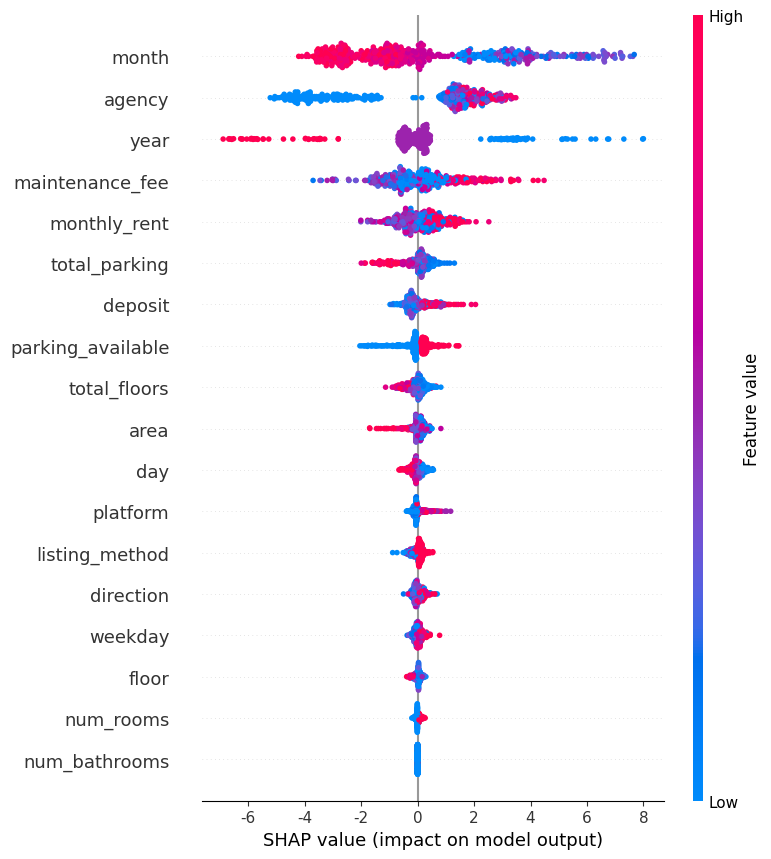

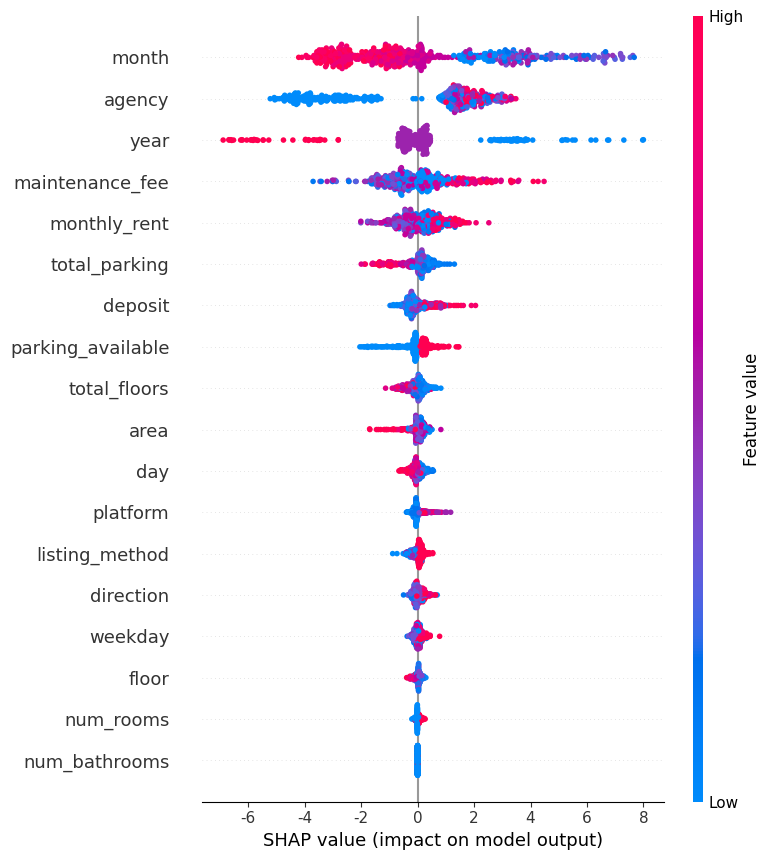

In [ ]:
plt.figure(figsize=(8, 6))  # 그림 크기 8x6 인치 지정
shap.summary_plot(shap_values, X_val, show=False)
plt.tight_layout()  # 레이아웃 조정
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()

# 두 번째: 기본 설정으로 plot 출력
shap.summary_plot(shap_values, X_val)

In [ ]:
explainer_r = shap.Explainer(rf_model, X_train)
shap_values_r = explainer(X_val, check_additivity=False)

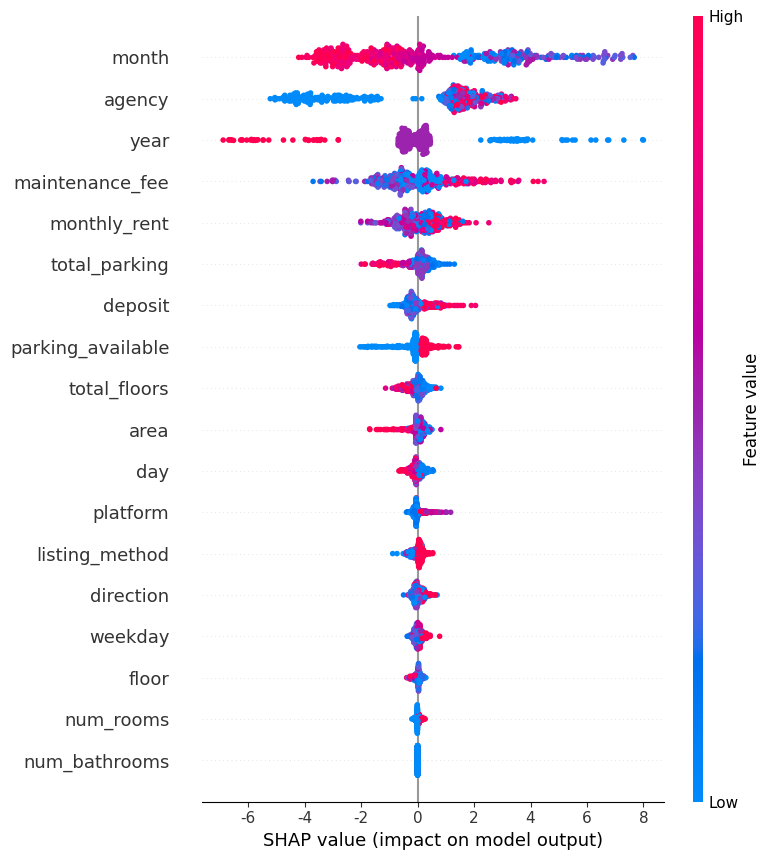

In [ ]:
shap.summary_plot(shap_values_r, X_val)

In [ ]:
explainer_l = shap.Explainer(lgbm_model, X_train)
shap_values_l = explainer(X_val, check_additivity=False)

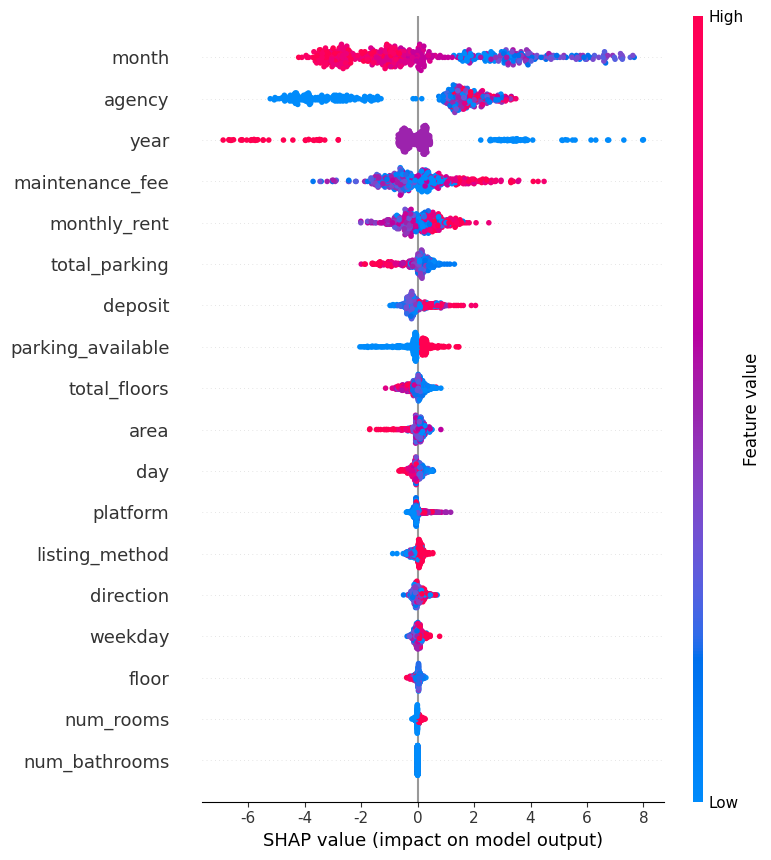

In [ ]:
shap.summary_plot(shap_values_l, X_val)